In [1]:
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics
from pathlib import Path
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# 解决中文乱码问题
plt.rcParams["font.sans-serif"]=["SimHei"] 
plt.rcParams["axes.unicode_minus"]=False 

In [2]:
data=pd.read_csv('./try.csv')
train_data,test_data=train_test_split(data,test_size=0.2, random_state=1318)
feature=train_data.drop(['Ea','Unnamed: 0'],axis=1)
label=train_data['Ea']
x_test=test_data.drop(['Ea','Unnamed: 0'],axis=1)
y_test=test_data['Ea']

In [3]:
kfold = KFold(n_splits = 5, random_state = 1314, shuffle = True)

In [22]:
def optuna_objective(trial):
    iterations=trial.suggest_int('iterations',100,1000,10)
    max_depth=trial.suggest_int("max_depth",2,15,1)
    l2_leaf_reg=trial.suggest_float("l2_leaf_reg",1,4)
    learning_rate=trial.suggest_float("learning_rate",0.05,0.3)
    reg=cb.CatBoostRegressor(iterations=iterations,
                             max_depth=max_depth,
                             l2_leaf_reg=l2_leaf_reg,
                             learning_rate=learning_rate,
                             silent=True
                             )
    loss=cross_val_score(reg,feature,label,cv=kfold,error_score='raise')
    return pow(abs(loss.mean()),0.5)

In [23]:
def optimizer_optuna(n_trials):
    algo=optuna.samplers.TPESampler(n_startup_trials=10,n_ei_candidates=24)
    study=optuna.create_study(sampler=algo,direction="maximize")
    study.optimize(optuna_objective,n_trials=n_trials,show_progress_bar=True)
    print("\n","\n","best params: ", study.best_trial.params,
          "\n","\n","best score: ", study.best_trial.values,
          "\n")
    
    return study.best_trial.params, study.best_trial.values

In [24]:
optimizer_optuna(10)

[I 2023-05-05 17:57:28,474] A new study created in memory with name: no-name-01f8b784-1022-4177-b336-b4645f0fcfc4


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-05-05 17:57:42,297] Trial 0 finished with value: 0.8664281329668383 and parameters: {'iterations': 630, 'max_depth': 9, 'l2_leaf_reg': 1.9631828083517897, 'learning_rate': 0.20572947878737413}. Best is trial 0 with value: 0.8664281329668383.
[I 2023-05-05 17:57:50,036] Trial 1 finished with value: 0.8676128094350759 and parameters: {'iterations': 570, 'max_depth': 8, 'l2_leaf_reg': 2.4634920138642387, 'learning_rate': 0.05788002280317346}. Best is trial 1 with value: 0.8676128094350759.
[I 2023-05-05 17:58:06,273] Trial 2 finished with value: 0.8570983871290122 and parameters: {'iterations': 770, 'max_depth': 9, 'l2_leaf_reg': 1.0945881330863445, 'learning_rate': 0.23988273687653922}. Best is trial 1 with value: 0.8676128094350759.
[I 2023-05-05 17:58:07,891] Trial 3 finished with value: 0.8429985579888548 and parameters: {'iterations': 920, 'max_depth': 2, 'l2_leaf_reg': 3.3499931910743204, 'learning_rate': 0.1617737310769461}. Best is trial 1 with value: 0.8676128094350759.
[

({'iterations': 190,
  'max_depth': 4,
  'l2_leaf_reg': 1.1678917747119768,
  'learning_rate': 0.08997988407863759},
 [0.8695838483591988])

In [4]:
model = cb.CatBoostRegressor(iterations=450,max_depth=6,l2_leaf_reg=2.258066272284123,silent=True,
                             random_state=1314,learning_rate=0.21344615004315326).fit(X=feature , y=label)
r2_score = cross_val_score(model, feature, label, cv=kfold, scoring='r2').mean()
rmse_score = pow(abs(cross_val_score(model, feature, label, cv=kfold, scoring='neg_mean_squared_error').mean()),0.5)
print('r2:',r2_score)
print('rmse:',rmse_score)

r2: 0.7271830919495159
rmse: 0.18723879064719995


In [5]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
print('r2:',r2_score(label,model.predict(feature)))
print('MAE:',mean_absolute_error(label,model.predict(feature)))
print('测试集得分为：', r2_score(y_test,model.predict(x_test)),mean_absolute_error(y_test,model.predict(x_test)))

r2: 0.9898952222793611
MAE: 0.005503322772465425
测试集得分为： 0.7948405629214368 0.11483728477083832


In [6]:
# 预测1
Y1=model.predict(test_data.drop(['Ea','Unnamed: 0'],axis=1))
Y2=test_data['Ea']
d={'Y_pred':Y1,
   'Y_True':Y2
   }
pred_show=pd.DataFrame(d)

In [7]:
# 预测2
Y_1=model.predict(feature)
Y_2=label
d_1={'Y_pred':Y_1,
   'Y_True':Y_2
   }
pred_show_1=pd.DataFrame(d_1)

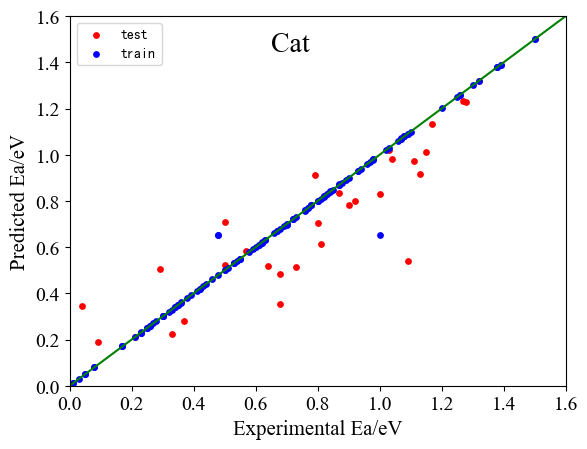

In [8]:
plt.scatter(pred_show.iloc[:,1],pred_show.iloc[:,0],color='r',s=15,label='test')
plt.scatter(pred_show_1.iloc[:,1],pred_show_1.iloc[:,0],color='b',s=15,label='train')
plt.xlim((0,1.6))
plt.xlabel('Experimental Ea/eV',fontsize=15,font=Path('..\TimesNewRoman.ttf'))
plt.xticks(fontsize=14,fontname='Times New Roman')
plt.ylim((0,1.6))
plt.ylabel('Predicted Ea/eV',fontsize=15,font=Path('..\TimesNewRoman.ttf'))
plt.yticks(fontsize=14,fontname='Times New Roman')
plt.plot([0,1.6],[0,1.6],color='g')
plt.text(0.65,1.45,'Cat',fontsize=20,font=Path('..\TimesNewRoman.ttf'))
plt.legend()
plt.show()

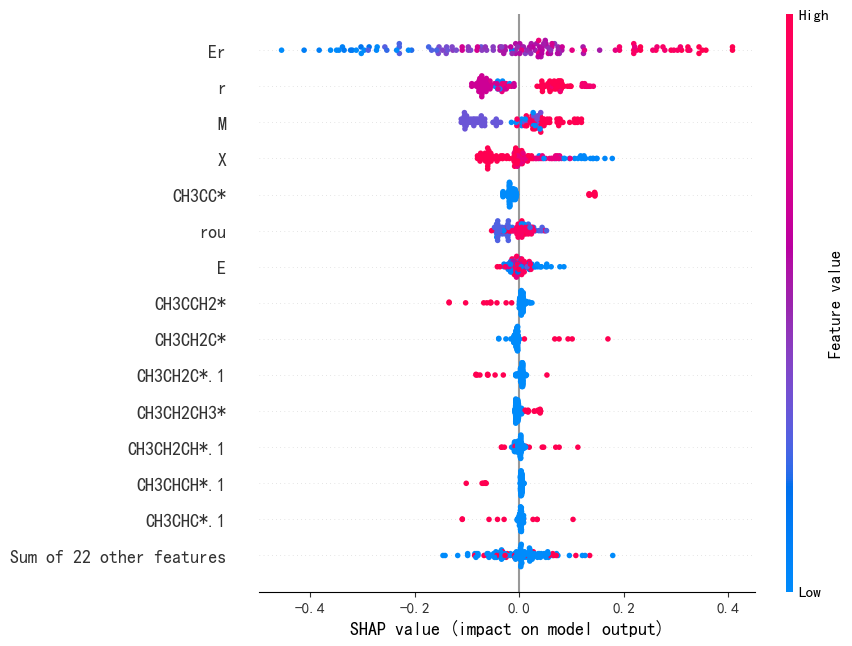

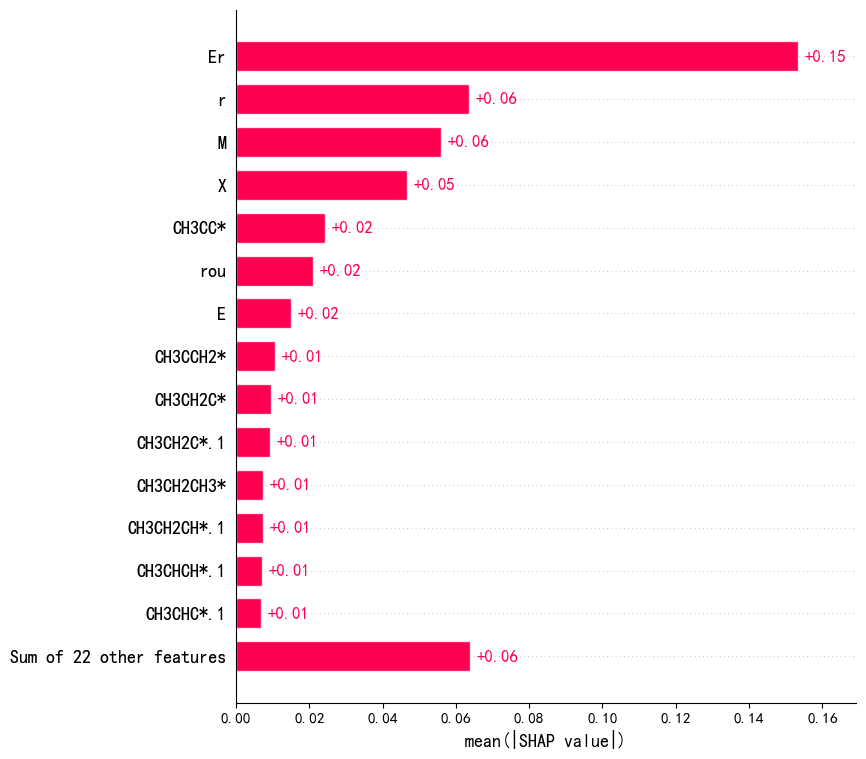

Glyph 8722 (\N{MINUS SIGN}) missing from current font.
Glyph 8722 (\N{MINUS SIGN}) missing from current font.


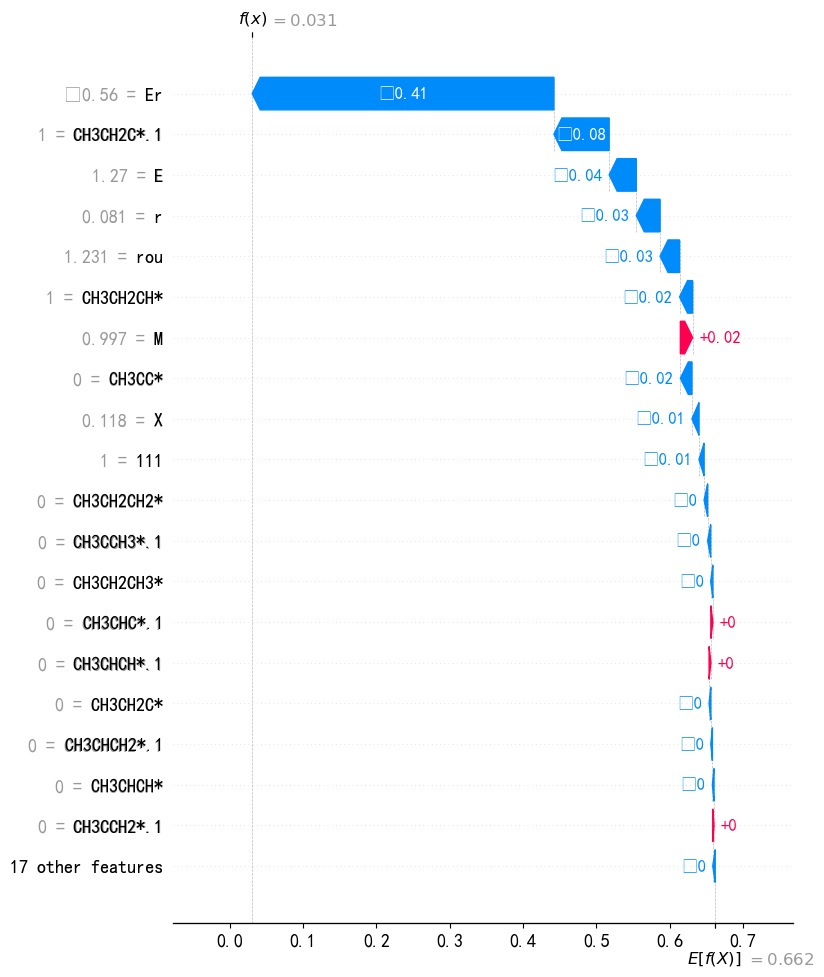

In [9]:
# shap提高解释性
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer(feature)
shap.plots.beeswarm(shap_values, max_display=15)
shap.plots.bar(shap_values, max_display=15)
shap.plots.waterfall(shap_values[0], max_display=20)
shap.plots.force(shap_values[0])
shap.force_plot(explainer.expected_value, shap_values.values, feature)